# Flight tracks

The P3 flew 95 hours of observations over eleven flights, many of which were coordinated
with the NOAA research ship R/V Ronald H. Brown and autonomous platforms deployed
from the ship. Each flight contained a mixture of sampling strategies including:
high-altitude circles with frequent dropsonde deployment to characterize the large-scale
environment; slow descents and ascents to measure the distribution of water vapor
and its isotopic composition; stacked legs aimed at sampling the microphysical
and thermodynamic state of the boundary layer; and offset straight flight legs for
observing clouds and the ocean surface with remote sensing instruments and the
thermal structure of the ocean with _in situ_ sensors dropped from the plane.

As a result of this diverse sampling the flight tracks are much more variable
then for most of the other aircraft.

General setup:

In [1]:
import xarray as xr
import numpy as np
import datetime
#
# Related to plotting
#
import matplotlib.pyplot as plt
plt.style.use(["./mplstyle/book"])
%matplotlib inline

Now access the flight track data.

In [2]:
import eurec4a
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

Mapping takes quite some setup. Maybe we'll encapsulate this later but for now we repeat code
in each notebook.

In [3]:
import matplotlib as mpl
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
from   cartopy.feature import LAND
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
def ax_to_map(ax, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    # Defining boundaries of the plot
    ax.set_extent([lon_w,lon_e,lat_s,lat_n]) # lon west, lon east, lat south, lat north
    ax.coastlines(resolution='10m',linewidth=1.5,zorder=1);
    ax.add_feature(LAND,facecolor='0.9')

def set_up_map(plt, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax_to_map(ax, lon_w, lon_e, lat_s, lat_n)
    return(ax)

def add_gridlines(ax):
    # Assigning axes ticks
    xticks = np.arange(-65,0,2.5)
    yticks = np.arange(0,25,2.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                      color='black', alpha=0.5, linestyle='dotted')
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    gl.right_labels = False
    gl.bottom_labels = False
    gl.xlabel = {'Latitude'}

What days did the P-3 fly on? We can find out via the flight segmentation files.

In [4]:
# On what days did the P-3 fly? These are UTC date
all_flight_segments = eurec4a.get_flight_segments()
flight_dates = np.unique([np.datetime64(flight["takeoff"]).astype("datetime64[D]")
                          for flight in all_flight_segments["P3"].values()])

Now set up colors to code each flight date during the experiment. One could choose
a categorical palette so the colors were as different from each other as possible.
Here we'll choose from a continuous set that spans the experiment so days that are
close in time are also close in color.

In [5]:
# Like mpl.colors.Normalize but works also with datetime64 objects
def mk_norm(vmin, vmax):
    def norm(values):
        return (values - vmin) / (vmax - vmin)
    return norm
norm = mk_norm(np.datetime64("2020-01-15"),
               np.datetime64("2020-02-15"))

# color map for things coded by flight date
#   Sample from a continuous color map running from start to end of experiment
def color_of_day(day):
    return plt.cm.viridis(norm(day), alpha=0.9)

For plotting purposes it'll be handy to define a one-day time window and to convert between date/time formats

In [6]:
one_day = np.timedelta64(1, "D")

def to_datetime(dt64):
    epoch = np.datetime64("1970-01-01")
    second = np.timedelta64(1, "s")
    return datetime.datetime.utcfromtimestamp((dt64 - epoch) / second)

Most platforms available from the EUREC⁴A `intake` catalog have a `tracks` element but
we'll use the `flight-level` data instead. We're using `xr.concat()` with one `dask` array per day
to avoid loading the whole dataset into memory at once.

In [7]:
nav_data = xr.concat([entry.to_dask().chunk() for entry in cat.P3.flight_level.values()],
                     dim = "time")

A map showing each of the eleven flight tracks:

/usr/share/miniconda/envs/how_to_eurec4a/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


/usr/share/miniconda/envs/how_to_eurec4a/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


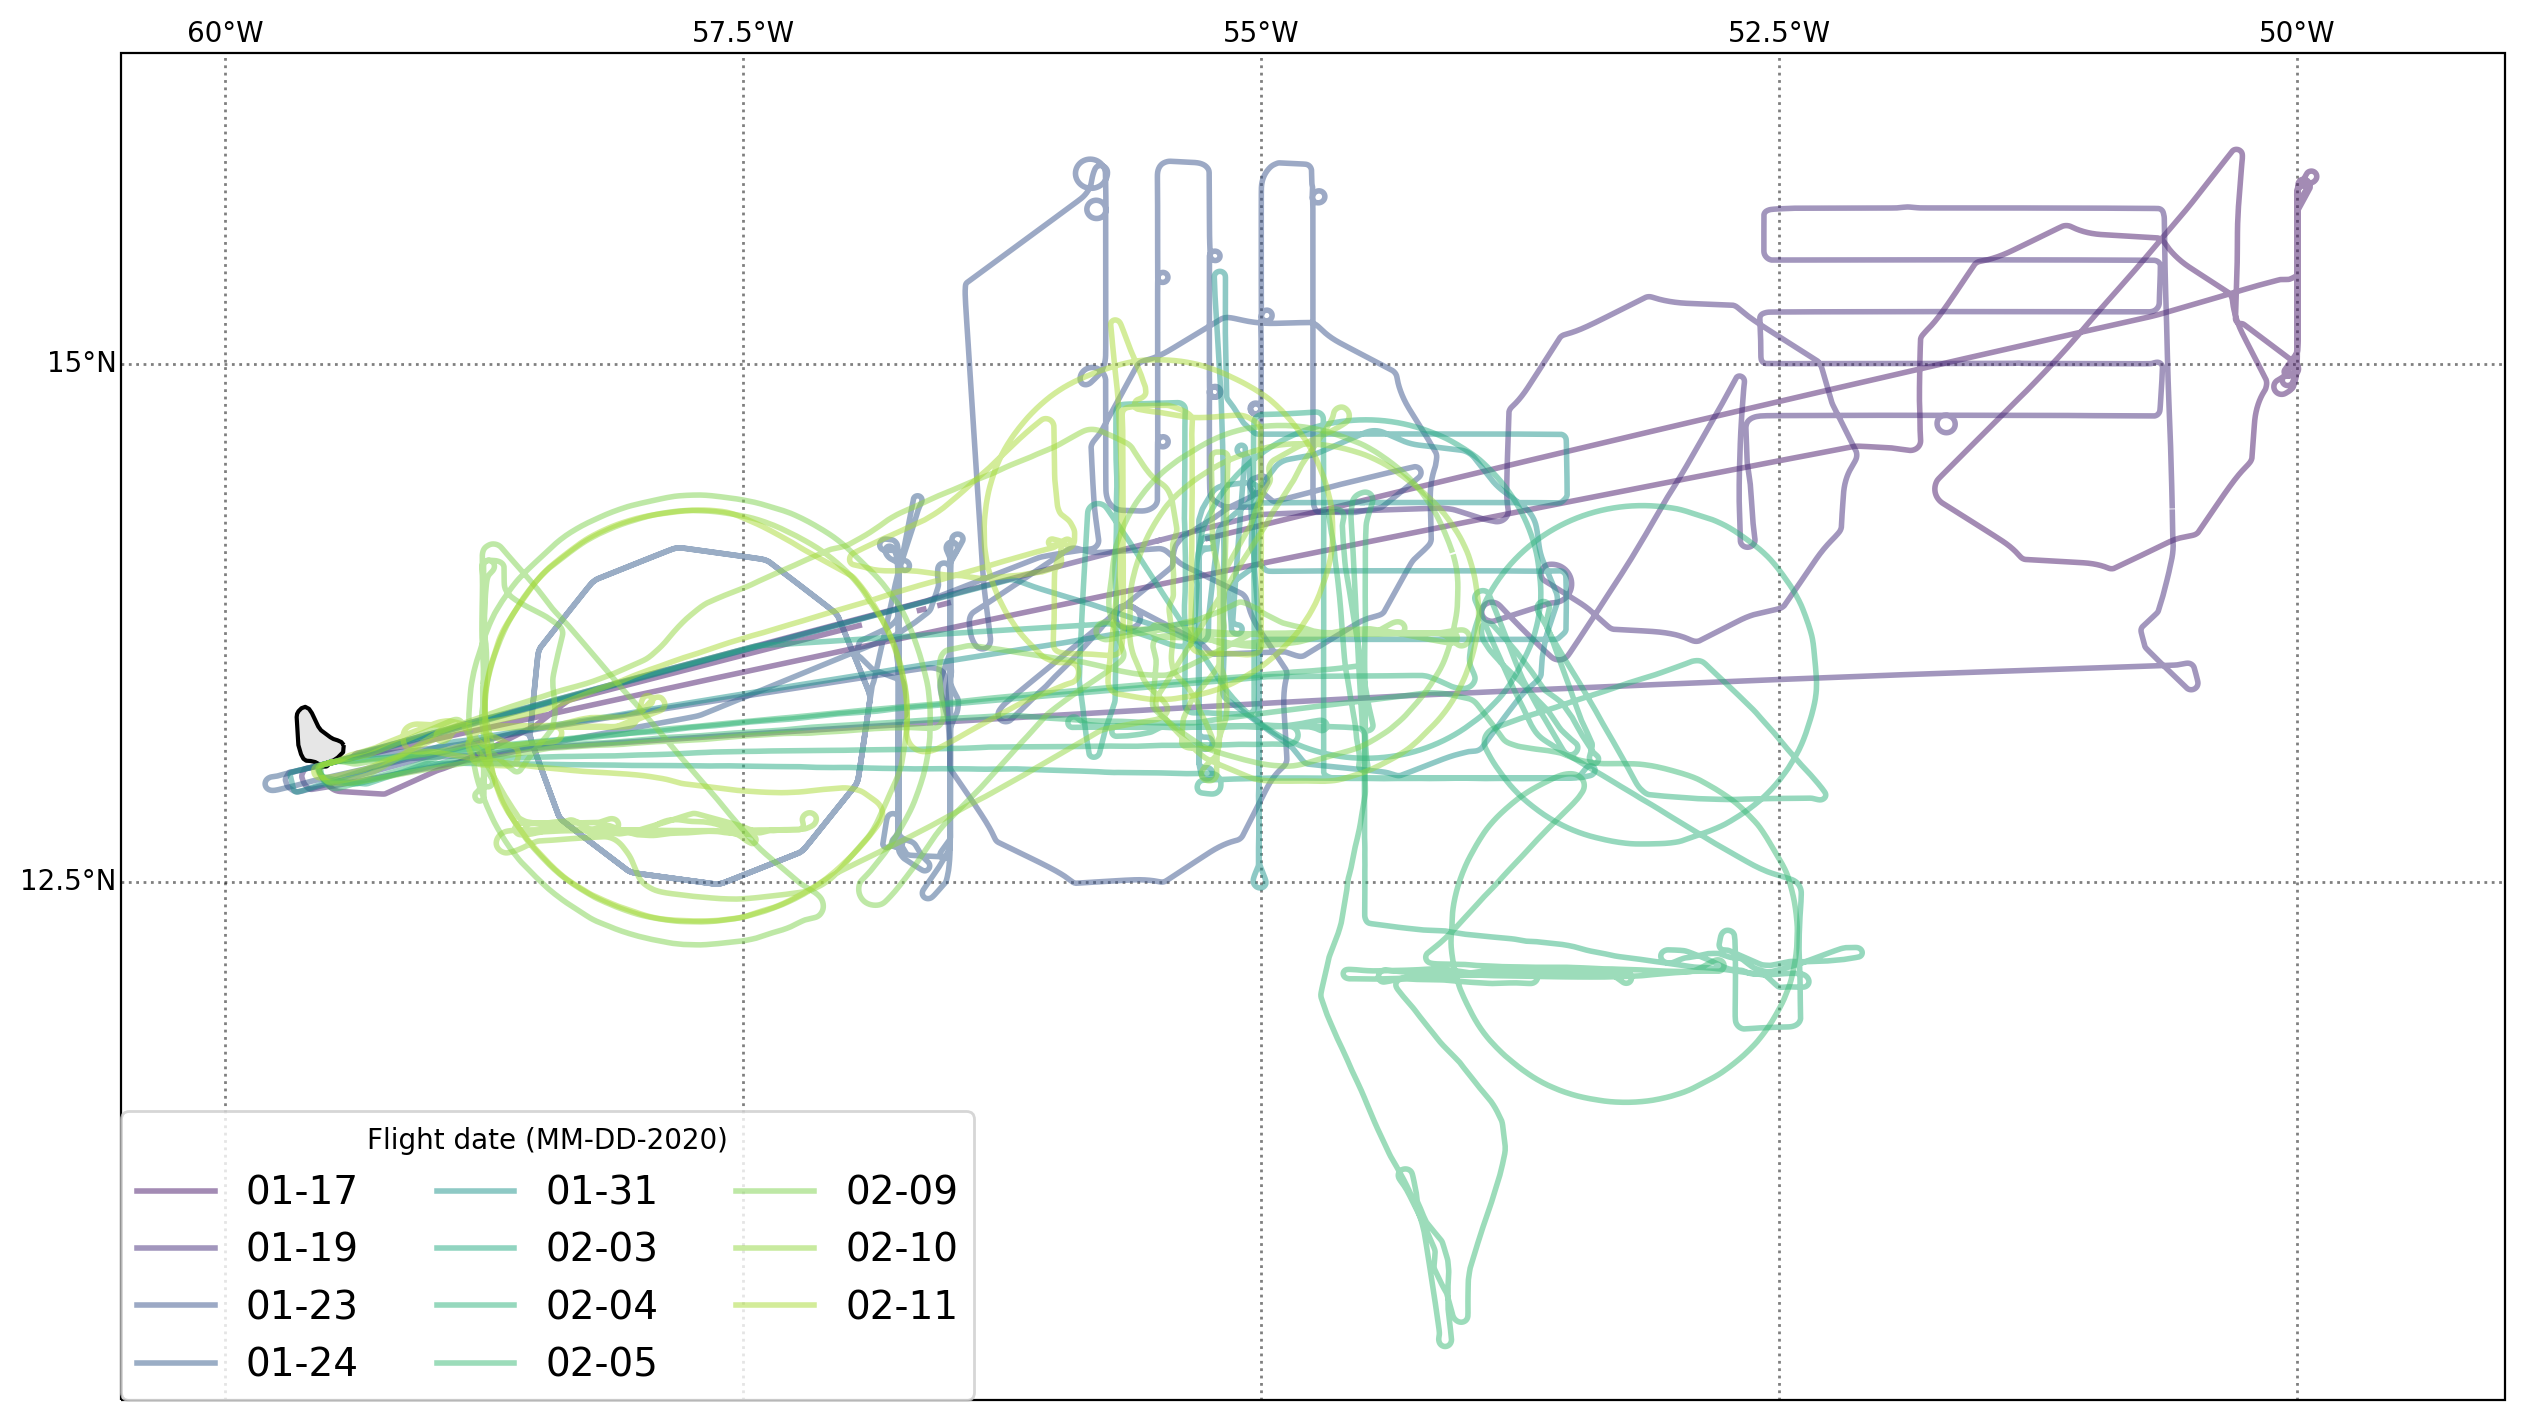

In [8]:
fig = plt.figure(figsize = (12,13.6))
ax  = set_up_map(plt)
add_gridlines(ax)

for d in flight_dates:
    flight = nav_data.sel(time=slice(d, d + one_day))
    ax.plot(flight.lon, flight.lat,
            lw=2, alpha=0.5, c=color_of_day(d),
            transform=ccrs.PlateCarree(), zorder=7,
            label=f"{to_datetime(d):%m-%d}")

plt.legend(ncol=3, loc=(0.0,0.0), fontsize=14, framealpha=0.8, markerscale=5,
           title="Flight date (MM-DD-2020)")

Most dropsondes were deployed from regular dodecagons during the first part of the
experiment with short turns after each dropsonde providing an off-nadir look at
the ocean surface useful for calibrating the W-band radar. A change in pilots midway
through the experiment led to dropsondes being deployed from circular flight tracks
starting on 31 Jan. AXBTs were deployed in lawnmower patterns (parallel offset legs)
with small loops sometimes employed to lengthen the time between AXBT deployment
to allow time for data acquisition given the device's slow fall speeds.  Profiling
and especially _in situ_ cloud sampling legs sometimes deviated from straight paths to avoid hazardous weather.


Side view using the same color scale:

Text(0, 0.5, 'Aircraft altitude (km)')

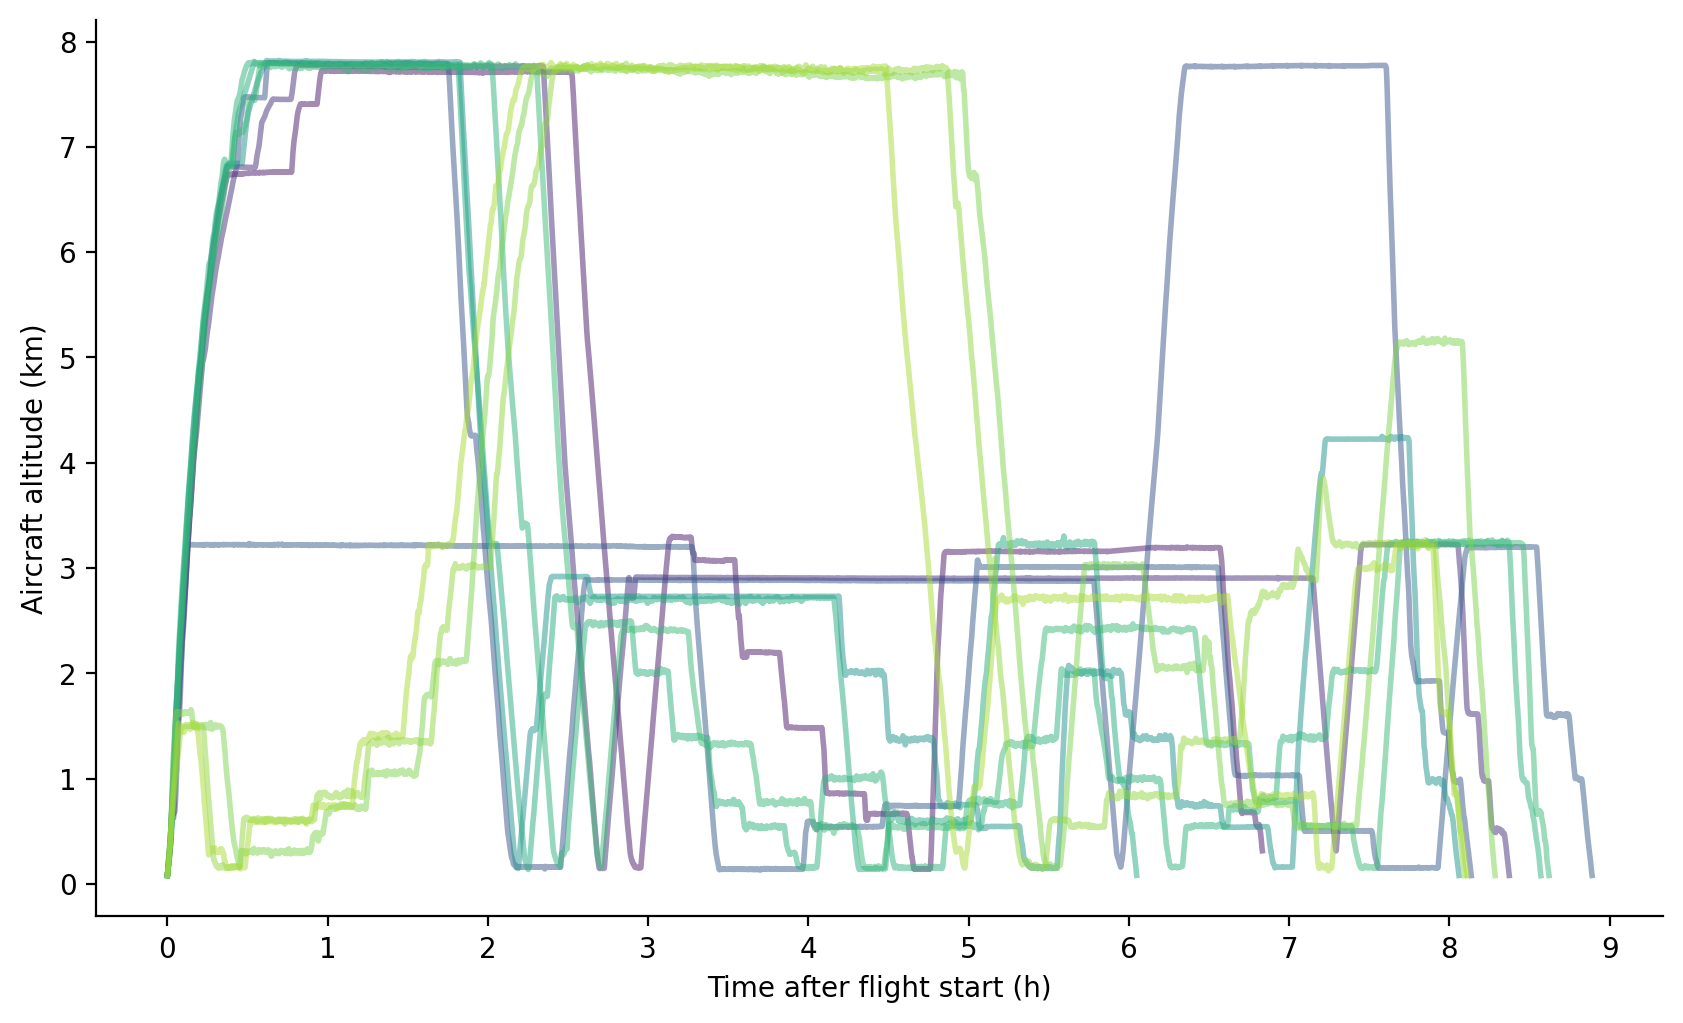

In [9]:
fig = plt.figure(figsize = (8.3,5))
ax = plt.axes()

for d in flight_dates:
    flight = nav_data.sel(time=slice(d, d + one_day))
    flight = flight.where(flight.alt > 80, drop=True) # Proxy for take-off time
    plt.plot(flight.time - flight.time.min(), flight.alt/1000.,
             lw=2, alpha=0.5, c=color_of_day(d),
             label=f"{to_datetime(d):%m-%d}")

plt.xticks(np.arange(10) * 3600 * 1e9, labels = np.arange(10))
ax.set_xlabel("Time after flight start (h)")
ax.set_ylabel("Aircraft altitude (km)")

Sondes were dropped from the P-3 at about 7.5 km, with each circle taking roughly an hour;
transits were frequently performed at this level  to conserve fuel. Long intervals
near 3 km altitude were used to deploy AXBTs and/or characterize the ocean surface
with remote sensing. Stepped legs indicate times devoted to _in situ_ cloud sampling.
On most flights the aircraft climbed quickly to roughly 7.5 km, partly to deconflict
with other aircraft participating in the experiment. On the three night flights,
however, no other aircraft were operating at take-off times and cloud sampling
was performed first, nearer Barbados than on other flights.